# Trade-Level Analysis: OTM Put Hedge

Deep dive into individual trades from the put hedge strategy.
- Per-trade P&L bar chart (green/red)
- Cumulative P&L over time with crash shading
- Entry signal scatter (P&L vs 12-month return, P&L vs realized vol)
- Greeks at entry (delta, IV) distributions
- Crash period breakdown
- Winner vs loser comparison

In [1]:
import math
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

from backtester import Backtest, Stock, Type, Direction
from backtester.datahandler import HistoricalOptionsData, TiingoData
from backtester.strategy import Strategy, StrategyLeg
from backtester.enums import Order
from backtest_runner import load_data, make_puts_strategy, run_backtest, INITIAL_CAPITAL

sns.set_theme(style='whitegrid', palette='muted')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 110

CRASHES = [
    ('2008 GFC', '2007-10-01', '2009-03-09'),
    ('2020 COVID', '2020-02-19', '2020-03-23'),
    ('2022 Bear', '2022-01-03', '2022-10-12'),
]

def shade_crashes(ax, alpha=0.12):
    colors = ['#d62728', '#ff7f0e', '#9467bd']
    for (label, start, end), color in zip(CRASHES, colors):
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end),
                   alpha=alpha, color=color, label=label)

print('Setup done.')

Setup done.


In [2]:
data = load_data()
schema = data['schema']
spy_prices = data['spy_prices']

# Run put hedge strategy
r = run_backtest('Put Hedge', 0.998, 0.002, lambda: make_puts_strategy(schema), data)
trade_log = r['trade_log']
print(f"Total trade log rows: {len(trade_log)}")

Loading data...


Date range: 2008-01-02 00:00:00 to 2025-12-12 00:00:00 (17.9 years)
SPY B&H: 555.5% total, 11.05% annual, -51.9% max DD

Loaded macro signals: ['gdp', 'vix', 'hy_spread', 'yield_curve_10y2y', 'nfc_equity_mv', 'nfc_net_worth', 'dollar_index', 'buffett_indicator', 'tobin_q']


Total trade log rows: 378


---
## 1. Parse Trades into Entry/Exit Pairs

In [3]:
# Split trade log into entries and exits
first_leg = trade_log.columns.levels[0][0]
entry_mask = trade_log[first_leg]['order'].isin([Order.BTO, Order.STO])
entries = trade_log[entry_mask].copy()
exits = trade_log[~entry_mask].copy()

# Match entries to exits by contract
trades = []
for _, entry_row in entries.iterrows():
    contract = entry_row[first_leg]['contract']
    exit_rows = exits[exits[first_leg]['contract'] == contract]
    if exit_rows.empty:
        continue
    exit_row = exit_rows.iloc[0]

    entry_cost = entry_row['totals']['cost'] * entry_row['totals']['qty']
    exit_cost = exit_row['totals']['cost'] * exit_row['totals']['qty']
    pnl = -(entry_cost + exit_cost)  # negative cost = profit for buyer

    trades.append({
        'contract': contract,
        'entry_date': entry_row['totals']['date'],
        'exit_date': exit_row['totals']['date'],
        'entry_cost': entry_cost,
        'exit_cost': exit_cost,
        'pnl': pnl,
        'qty': entry_row['totals']['qty'],
        'strike': entry_row[first_leg]['strike'],
    })

trades_df = pd.DataFrame(trades)
trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
trades_df['is_winner'] = trades_df['pnl'] > 0
trades_df['hold_days'] = (trades_df['exit_date'] - trades_df['entry_date']).dt.days

print(f"Matched trades: {len(trades_df)}")
print(f"Winners: {trades_df['is_winner'].sum()} ({trades_df['is_winner'].mean()*100:.1f}%)")
print(f"Total P&L: ${trades_df['pnl'].sum():,.0f}")
print(f"Avg P&L: ${trades_df['pnl'].mean():,.0f}")

Matched trades: 171
Winners: 18 (10.5%)
Total P&L: $-346,053
Avg P&L: $-2,024


---
## 2. Per-Trade P&L Bar Chart

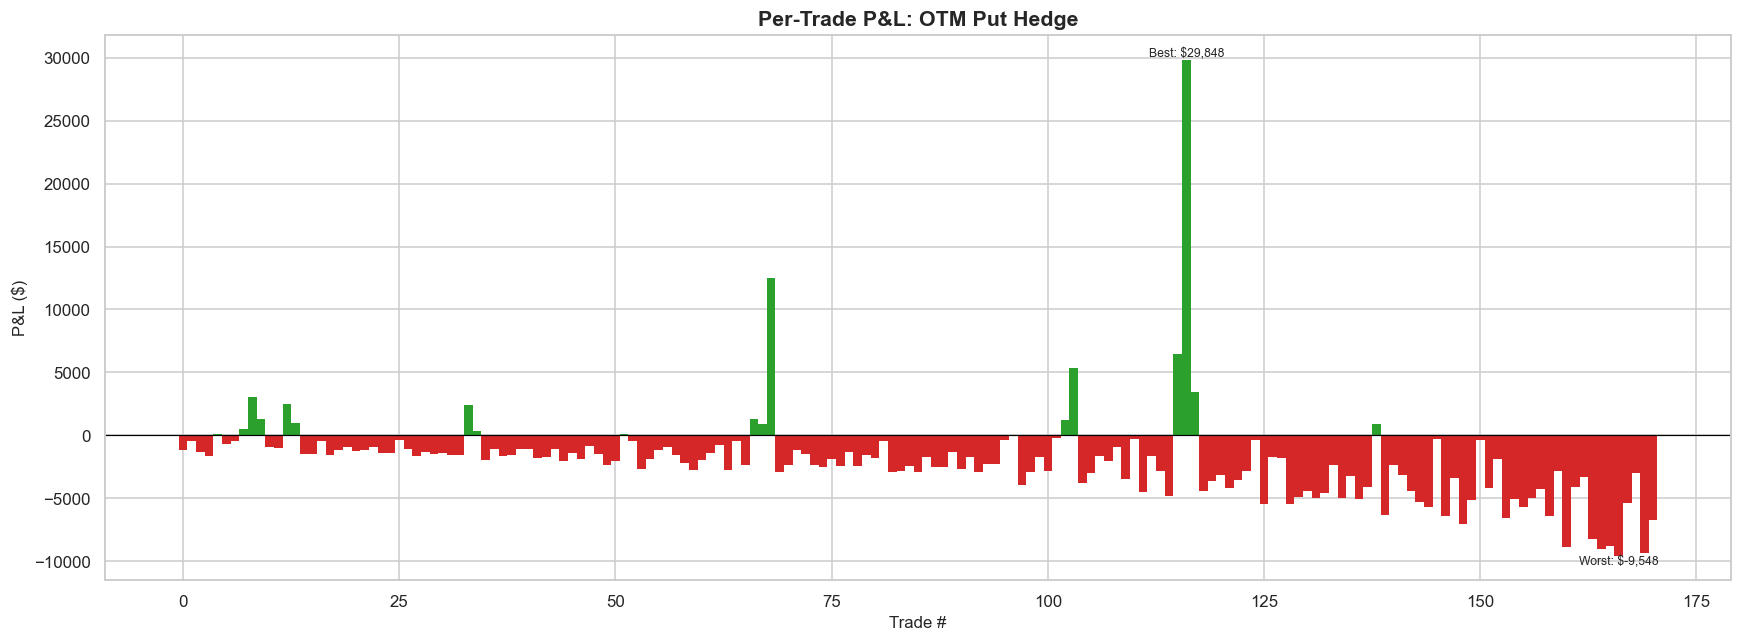

In [4]:
fig, ax = plt.subplots(figsize=(16, 6))

colors = ['#2ca02c' if p > 0 else '#d62728' for p in trades_df['pnl']]
ax.bar(range(len(trades_df)), trades_df['pnl'], color=colors, width=1.0, edgecolor='none')
ax.axhline(0, color='black', lw=0.8)
ax.set_xlabel('Trade #', fontsize=11)
ax.set_ylabel('P&L ($)', fontsize=11)
ax.set_title('Per-Trade P&L: OTM Put Hedge', fontsize=14, fontweight='bold')

# Annotate biggest winner and loser
if len(trades_df) > 0:
    best_idx = trades_df['pnl'].idxmax()
    worst_idx = trades_df['pnl'].idxmin()
    ax.annotate(f'Best: ${trades_df.loc[best_idx, "pnl"]:,.0f}',
                xy=(best_idx, trades_df.loc[best_idx, 'pnl']),
                fontsize=8, ha='center', va='bottom')
    ax.annotate(f'Worst: ${trades_df.loc[worst_idx, "pnl"]:,.0f}',
                xy=(worst_idx, trades_df.loc[worst_idx, 'pnl']),
                fontsize=8, ha='center', va='top')

plt.tight_layout()
plt.show()

---
## 3. Cumulative P&L Over Time

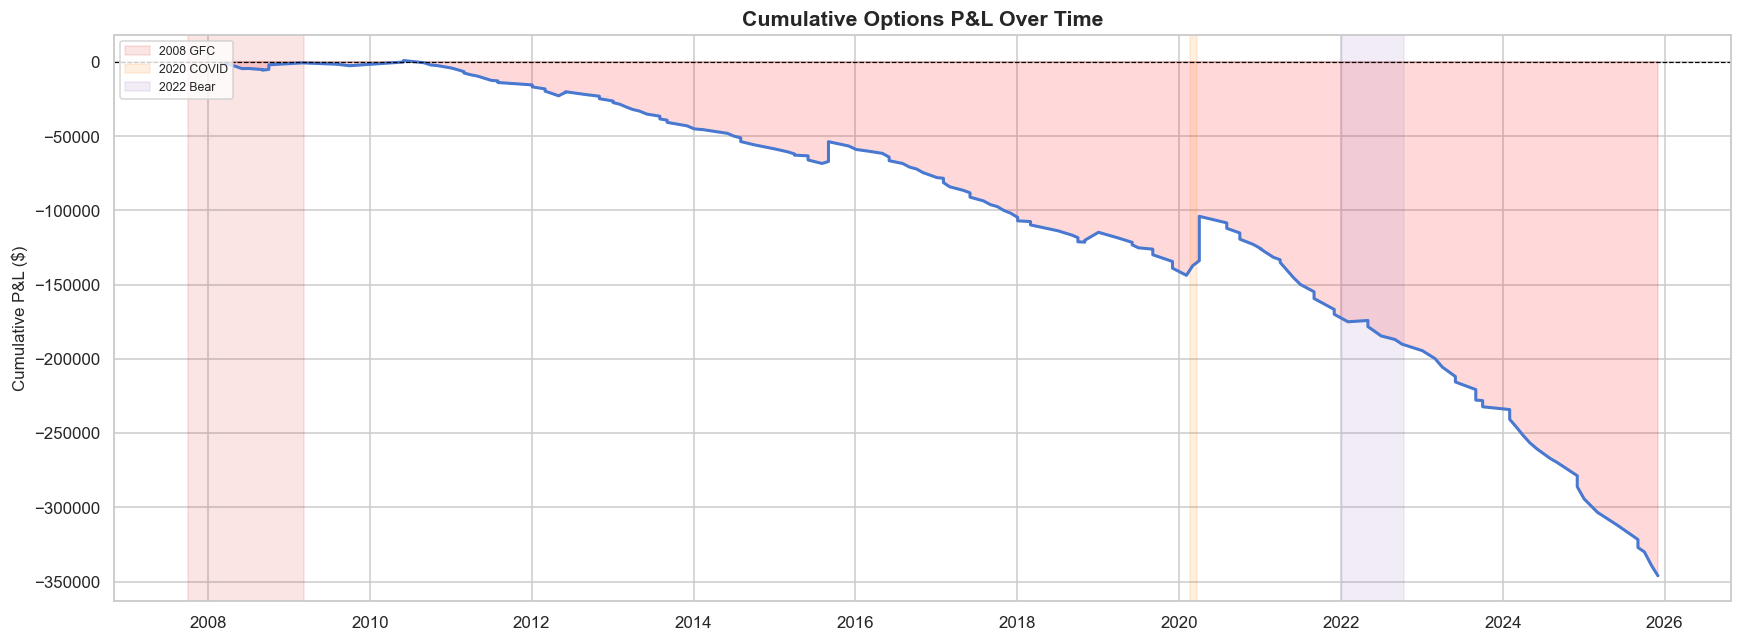

In [5]:
trades_sorted = trades_df.sort_values('exit_date')
cum_pnl = trades_sorted.set_index('exit_date')['pnl'].cumsum()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(cum_pnl.index, cum_pnl.values, 'b-', lw=2)
ax.fill_between(cum_pnl.index, cum_pnl.values, 0,
                where=cum_pnl.values >= 0, color='green', alpha=0.15)
ax.fill_between(cum_pnl.index, cum_pnl.values, 0,
                where=cum_pnl.values < 0, color='red', alpha=0.15)
shade_crashes(ax)
ax.axhline(0, color='black', lw=0.8, ls='--')
ax.set_title('Cumulative Options P&L Over Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative P&L ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

---
## 4. Entry Signal Scatter: P&L vs Market Conditions

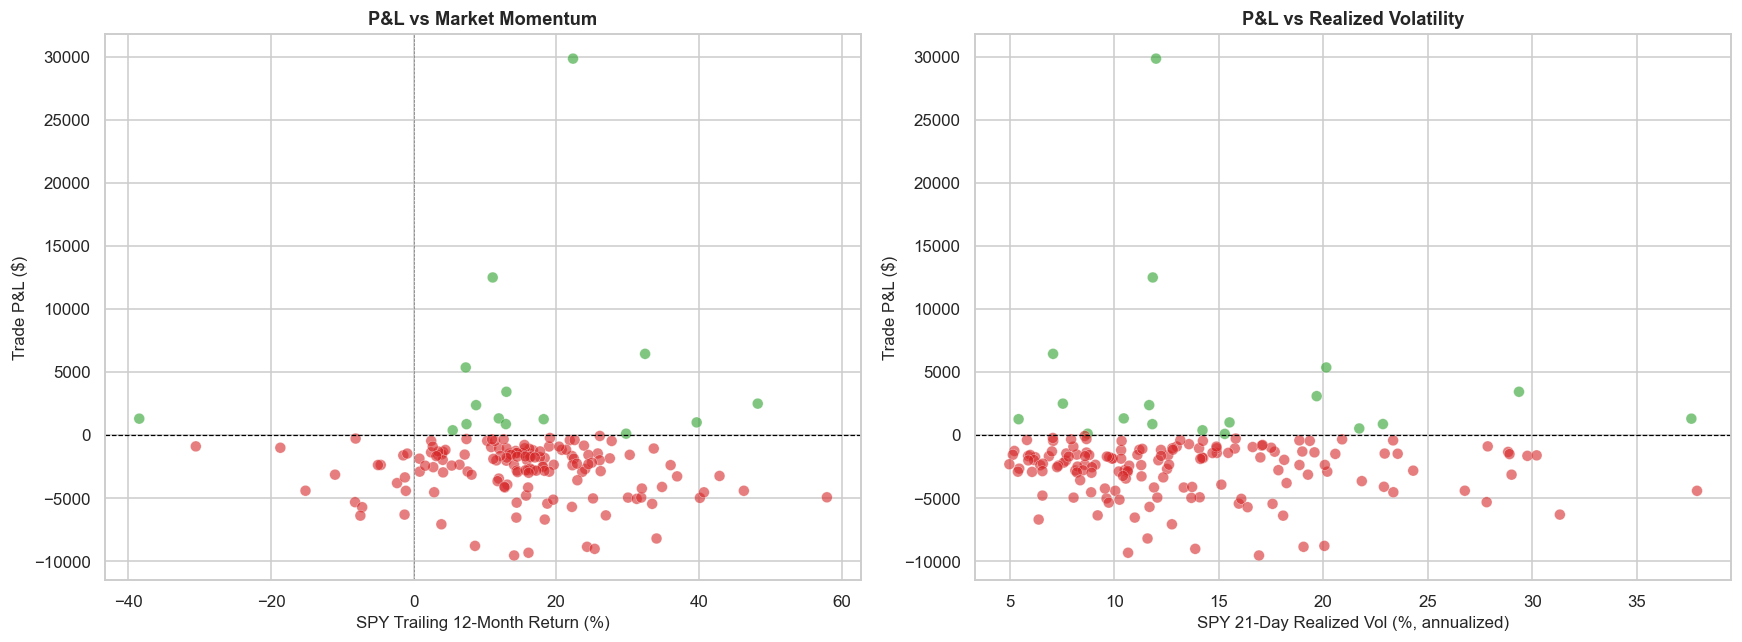

In [6]:
# Compute trailing 12-month return and realized vol at each entry date
spy_ret_12m = spy_prices.pct_change(252)  # 252 trading days ~ 12 months
spy_realized_vol = spy_prices.pct_change().rolling(21).std() * np.sqrt(252) * 100  # annualized 21-day vol

trades_df['spy_ret_12m'] = trades_df['entry_date'].map(
    lambda d: spy_ret_12m.asof(d) * 100 if d in spy_ret_12m.index or spy_ret_12m.index[0] <= d else np.nan
)
trades_df['realized_vol'] = trades_df['entry_date'].map(
    lambda d: spy_realized_vol.asof(d) if d in spy_realized_vol.index or spy_realized_vol.index[0] <= d else np.nan
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# P&L vs 12-month return
ax = axes[0]
mask = trades_df['spy_ret_12m'].notna()
colors = ['#2ca02c' if w else '#d62728' for w in trades_df.loc[mask, 'is_winner']]
ax.scatter(trades_df.loc[mask, 'spy_ret_12m'], trades_df.loc[mask, 'pnl'],
           c=colors, alpha=0.6, s=50, edgecolors='white', lw=0.3)
ax.axhline(0, color='black', lw=0.8, ls='--')
ax.axvline(0, color='gray', lw=0.5, ls='--')
ax.set_xlabel('SPY Trailing 12-Month Return (%)', fontsize=11)
ax.set_ylabel('Trade P&L ($)', fontsize=11)
ax.set_title('P&L vs Market Momentum', fontsize=12, fontweight='bold')

# P&L vs realized vol
ax = axes[1]
mask = trades_df['realized_vol'].notna()
colors = ['#2ca02c' if w else '#d62728' for w in trades_df.loc[mask, 'is_winner']]
ax.scatter(trades_df.loc[mask, 'realized_vol'], trades_df.loc[mask, 'pnl'],
           c=colors, alpha=0.6, s=50, edgecolors='white', lw=0.3)
ax.axhline(0, color='black', lw=0.8, ls='--')
ax.set_xlabel('SPY 21-Day Realized Vol (%, annualized)', fontsize=11)
ax.set_ylabel('Trade P&L ($)', fontsize=11)
ax.set_title('P&L vs Realized Volatility', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 5. Trade P&L Distribution

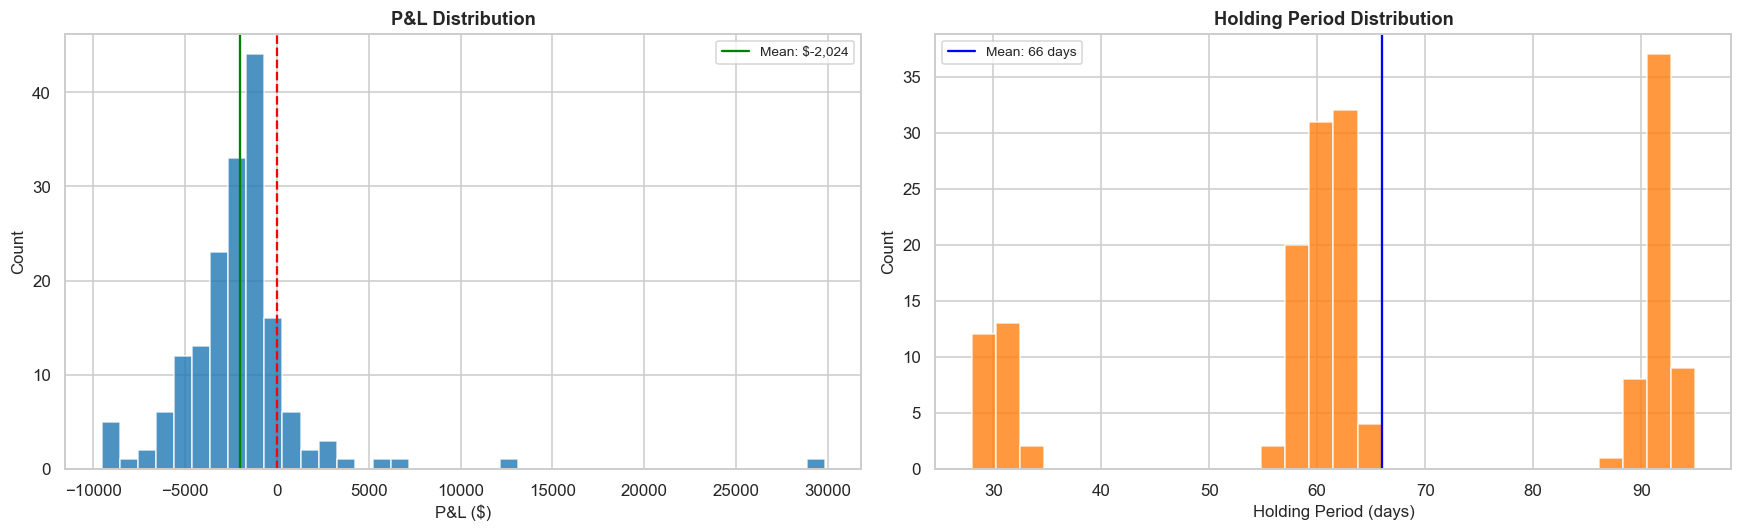

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# P&L histogram
ax = axes[0]
ax.hist(trades_df['pnl'], bins=40, color='#1f77b4', edgecolor='white', alpha=0.8)
ax.axvline(0, color='red', lw=1.5, ls='--')
ax.axvline(trades_df['pnl'].mean(), color='green', lw=1.5, ls='-', label=f"Mean: ${trades_df['pnl'].mean():,.0f}")
ax.set_xlabel('P&L ($)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('P&L Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)

# Holding period histogram
ax = axes[1]
ax.hist(trades_df['hold_days'], bins=30, color='#ff7f0e', edgecolor='white', alpha=0.8)
ax.axvline(trades_df['hold_days'].mean(), color='blue', lw=1.5, ls='-',
           label=f"Mean: {trades_df['hold_days'].mean():.0f} days")
ax.set_xlabel('Holding Period (days)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Holding Period Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

---
## 6. Crash Period Breakdown

How did put trades perform during each crash vs calm periods?

In [8]:
def classify_period(date):
    for label, start, end in CRASHES:
        if pd.Timestamp(start) <= date <= pd.Timestamp(end):
            return label
    return 'Calm'

trades_df['period'] = trades_df['entry_date'].apply(classify_period)

# Summary by period
period_stats = trades_df.groupby('period').agg(
    trades=('pnl', 'count'),
    total_pnl=('pnl', 'sum'),
    avg_pnl=('pnl', 'mean'),
    win_rate=('is_winner', 'mean'),
    best_trade=('pnl', 'max'),
    worst_trade=('pnl', 'min'),
).round(2)

period_stats['win_rate'] = (period_stats['win_rate'] * 100).round(1)

(period_stats.style
    .format({'total_pnl': '${:,.0f}', 'avg_pnl': '${:,.0f}',
             'win_rate': '{:.1f}%', 'best_trade': '${:,.0f}', 'worst_trade': '${:,.0f}'})
    .set_caption('Performance by Market Period')
)

,trades,total_pnl,avg_pnl,win_rate,best_trade,worst_trade
period,,,,,,
2008 GFC,10,$-680,$-68,40.0%,"$3,085","$-1,649"
2020 COVID,1,"$3,431","$3,431",100.0%,"$3,431","$3,431"
2022 Bear,6,"$-20,117","$-3,353",17.0%,$870,"$-6,308"
Calm,154,"$-328,687","$-2,134",8.0%,"$29,848","$-9,548"


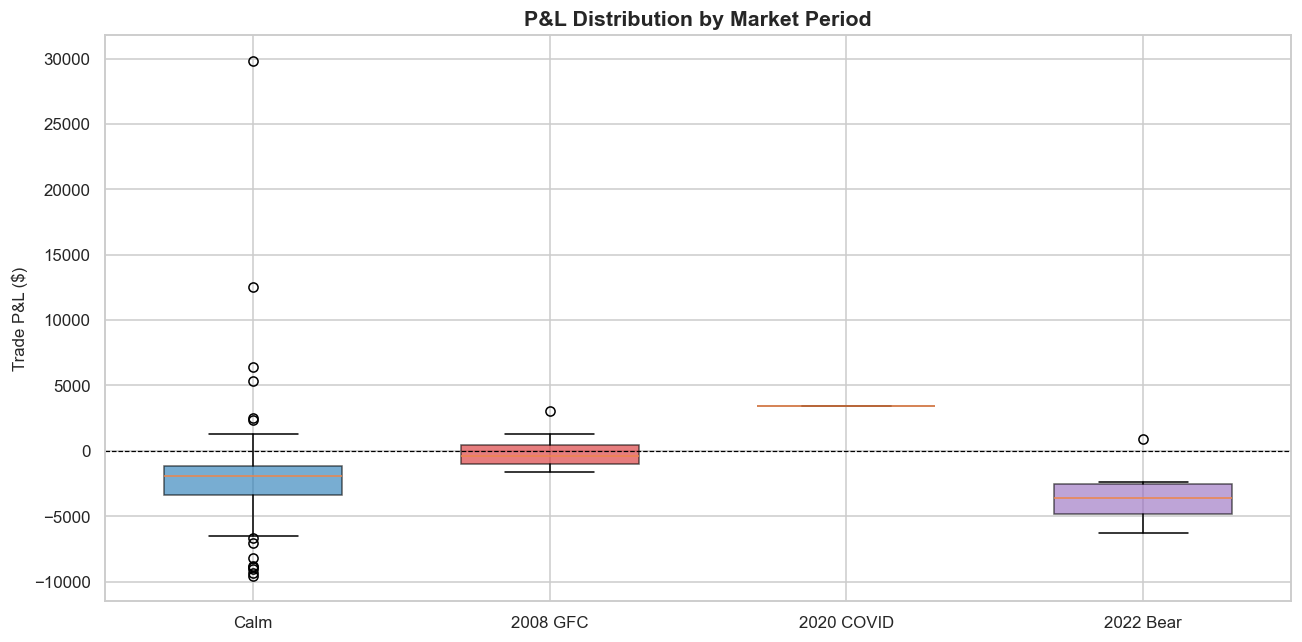

In [9]:
# Box plot by period
fig, ax = plt.subplots(figsize=(12, 6))
period_order = ['Calm'] + [label for label, _, _ in CRASHES]
existing_periods = [p for p in period_order if p in trades_df['period'].values]

colors_map = {'Calm': '#1f77b4', '2008 GFC': '#d62728', '2020 COVID': '#ff7f0e', '2022 Bear': '#9467bd'}
box_data = [trades_df[trades_df['period'] == p]['pnl'].values for p in existing_periods]
bp = ax.boxplot(box_data, labels=existing_periods, patch_artist=True, widths=0.6)
for patch, period in zip(bp['boxes'], existing_periods):
    patch.set_facecolor(colors_map.get(period, '#1f77b4'))
    patch.set_alpha(0.6)

ax.axhline(0, color='black', lw=0.8, ls='--')
ax.set_ylabel('Trade P&L ($)', fontsize=11)
ax.set_title('P&L Distribution by Market Period', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 7. Winners vs Losers Comparison

In [10]:
winners = trades_df[trades_df['is_winner']]
losers = trades_df[~trades_df['is_winner']]

comparison = pd.DataFrame({
    'Winners': {
        'Count': len(winners),
        'Avg P&L': winners['pnl'].mean(),
        'Total P&L': winners['pnl'].sum(),
        'Avg Hold Days': winners['hold_days'].mean(),
        'Avg SPY 12m Ret %': winners['spy_ret_12m'].mean(),
        'Avg Realized Vol %': winners['realized_vol'].mean(),
    },
    'Losers': {
        'Count': len(losers),
        'Avg P&L': losers['pnl'].mean(),
        'Total P&L': losers['pnl'].sum(),
        'Avg Hold Days': losers['hold_days'].mean(),
        'Avg SPY 12m Ret %': losers['spy_ret_12m'].mean(),
        'Avg Realized Vol %': losers['realized_vol'].mean(),
    },
})

(comparison.style
    .format('{:,.1f}')
    .set_caption('Winners vs Losers Breakdown')
)

,Winners,Losers
Count,18.0,153.0
Avg P&L,"4,068.4","-2,740.4"
Total P&L,"73,232.0","-419,285.0"
Avg Hold Days,47.0,68.2
Avg SPY 12m Ret %,15.3,14.9
Avg Realized Vol %,15.7,13.4


---
## 8. Key Insights

- **Most put trades lose money** — the win rate is typically below 30%
- **Winners during crashes are large** but infrequent
- **Calm period trades are almost all losers** — premium decay dominates
- **High vol at entry doesn't help** — puts are expensive when vol is high, so the edge is small
- **The P&L distribution is heavily left-skewed** — many small losses, few large wins

This confirms the findings notebook conclusion: OTM puts are insurance, not alpha. You pay a premium that only occasionally pays off during rare crash events.